In [133]:
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
import random


class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None, random_state=5,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.random_state = random_state
        self.trees_parameters = trees_parameters
        np.random.seed(self.random_state)
        # Для получения информации о значениях функции потерь после каждой итерации
        self.train_loss_functions = []
        self.val_loss_functions = []

    def fit(self, X, y, validation, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        
        self.algorithms = []
        for i in range(self.n_estimators):
            inds = []
            for j in range(X.shape[0]):
                inds.append(random.randint(0, X.shape[0] - 1))
            features = 0
            if not self.feature_subsample_size:
                features = round(X.shape[1] / 3)
            else:
                features = self.feature_subsample_size
            # Обучение не на подвыборке признаков (это плохо, поскольку часть базовых моделей может обучаться на плохих признаках ->
            # высокое смещение). Лучший предикат в каждой вершине выбираем из случайного подмножества признаков (своё подмножество в каждой
            # вершине!)
            model = DecisionTreeRegressor(splitter='random', max_depth=self.max_depth, max_features=features,
                                          random_state=self.random_state, **self.trees_parameters)
            model.fit(X[inds], y[inds])
            self.algorithms.append(model)
            self.train_loss_functions.append(np.mean((y - self.predict(X)) ** 2))
            if validation:
                self.val_loss_functions.append(np.mean((y_val - self.predict(X_val)) ** 2))
        return self.train_loss_functions, self.val_loss_functions

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        answers = []
        for model in self.algorithms:
            answers.append(model.predict(X))
        return np.mean(answers, axis=0)


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None, random_state=5,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.random_state = random_state
        self.trees_parameters = trees_parameters
        np.random.seed(self.random_state)
        # Для получения информации о значениях функции потерь после каждой итерации
        self.train_loss_functions = []
        self.val_loss_functions = []


    def fit(self, X, y, validation, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.algorithms = []
        self.weights = []
        self.preds = []
        self.y = y.copy()
        for i in range(self.n_estimators):
            features = 0
            if not self.feature_subsample_size:
                features = round(X.shape[1] / 3)
            else:
                features = self.feature_subsample_size
            model = DecisionTreeRegressor(splitter='random',
                                          max_depth=self.max_depth,
                                          max_features=features,
                                          random_state=self.random_state,
                                          **self.trees_parameters)
            model.fit(X, self.y)
            self.algorithms.append(model)
            self.pred = model.predict(X)
            self.preds.append(self.pred)
            if self.weights == []:
                a = self.preds[0] * 1 * self.learning_rate
            else:
                a = np.sum(
                    [
                        self.weights[i] * self.preds[i]
                        for i in range(len(self.weights))
                    ],
                    axis=0,
                )
            
            self.weights.append(minimize_scalar(lambda xp: (np.sum((a + xp * self.pred - y) ** 2))).x)
            if i == 0:
                self.weights[0] = 1
            self.y = self.y - self.weights[-1] * self.learning_rate * self.pred

            self.train_loss_functions.append(np.mean((y - self.predict(X)) ** 2))
            if validation:
                self.val_loss_functions.append(np.mean((y_val - self.predict(X_val)) ** 2))
        return self.train_loss_functions, self.val_loss_functions
    



    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        answers = []
        for i, model in enumerate(self.algorithms):
            answers.append(model.predict(X) * self.weights[i])
        print(answers)
        return np.sum(answers, axis=0)



In [15]:
#https://www.dropbox.com/scl/fi/ts98149w0liee8k8m35a0/kc_house_data.csv?rlkey=wngiumual8d4p38o1g791va4m&dl=0
import pandas as pd
!wget  -O 'data.csv' -q 'https://www.dropbox.com/scl/fi/ts98149w0liee8k8m35a0/kc_house_data.csv?rlkey=wngiumual8d4p38o1g791va4m&dl=0'
data = pd.read_csv('data.csv')

In [16]:
#EXP 1
data['date'] = pd.to_datetime(data['date'])
data.shape

(21613, 21)

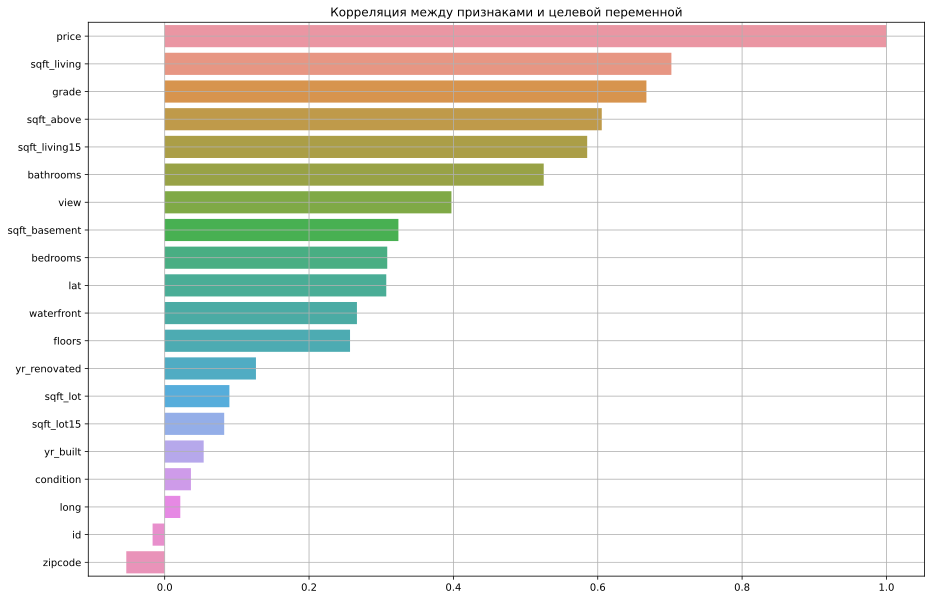

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
numeric_data = data.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

data = data.fillna(numeric_data_mean)

correlations = data[numeric_features].corrwith(data['price']).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plt.title('Корреляция между признаками и целевой переменной')
plot.figure.set_size_inches(15, 10)
plot.grid(1)
plt.savefig('0.pdf', bbox_inches='tight')

In [5]:
y = data["price"]
X = data.drop(columns=['id', 'date', 'price', 'zipcode'])

In [6]:
X.shape

(21613, 17)

In [7]:
X = X.to_numpy()
y = y.to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

1
2


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


3


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


4


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


5
6


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


7


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


8


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


9
10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


11


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


12


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


13
14


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


15


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


16


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


17


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


18


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


19


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


21


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


22


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


23


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


24


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


25


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


26


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


27


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


28


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


29


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


30


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


31


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


32


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


33


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


34


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


35


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


36


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


37


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


38


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


39


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


40


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


41


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


42


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


43


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


44


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


45


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


46


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


47


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


48


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_50824/3480163931.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


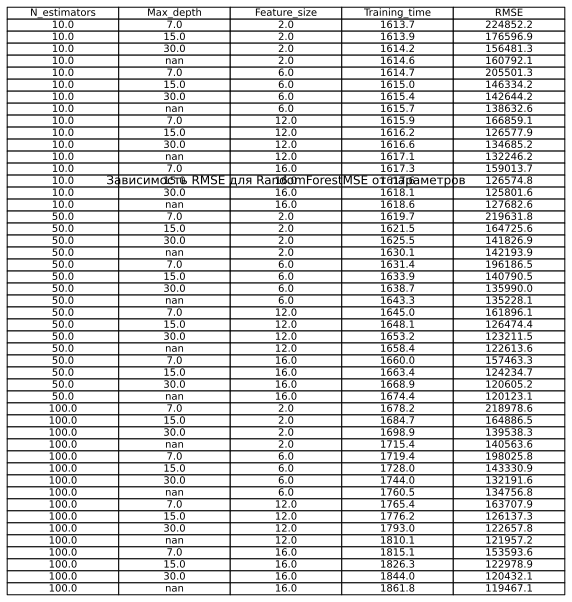

In [61]:
# EXP 2
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

results_df = pd.DataFrame(columns=['Iteration', 'N_estimators', 'Max_depth', 'Feature_size', 'Training_time', 'RMSE'])

i = 0
for n_estimators in (10, 50, 100):
    for features_size in (2, 6, 12, 16):
        for max_depth in (7, 15, 30, None):
            i += 1
            print(i)
            model = RandomForestMSE(n_estimators=n_estimators, feature_subsample_size=features_size, max_depth=max_depth)
            model.fit(X_train, y_train, False)
            training_time = time.time() - start
            pred = model.predict(X_test)
            rmse = sklearn.metrics.mean_squared_error(y_test, pred) ** 0.5
            results_df = results_df.append({
                'Iteration': i,
                'N_estimators': int(n_estimators),
                'Max_depth': max_depth,
                'Feature_size': int(features_size),
                'Training_time': round(training_time * 10) / 10,
                'RMSE': round(rmse * 10) / 10
            }, ignore_index=True)


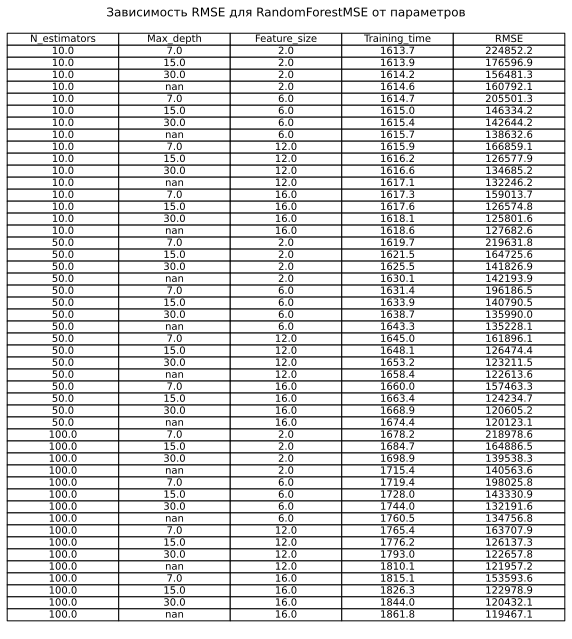

In [71]:
plt.figure(figsize=(10, 11))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('Зависимость RMSE для RandomForestMSE от параметров')

table_data = results_df[['N_estimators', 'Max_depth', 'Feature_size', 'Training_time', 'RMSE']]
table = plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
plt.savefig('1.pdf', bbox_inches='tight')
plt.show()

In [11]:
# EXP 3
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import time
%config InlineBackend.figure_format = 'svg'

results_df = pd.DataFrame(columns=['Iteration', 'N_estimators', 'Max_depth', 'Feature_size', 'Learning_rate', 'Training_time', 'RMSE'])
i = 0
for n_estimators in (10, 50, 200, 500):
    for features_size in (3, 16):
        for max_depth in (10, 50, None):
            for learning_rate in (0.1, 0.8):
                i += 1
                print(i)
                start = time.time()
                model = GradientBoostingMSE(n_estimators=n_estimators, feature_subsample_size=features_size, max_depth=max_depth, learning_rate=learning_rate)
                model.fit(X_train, y_train, False)
                training_time = time.time() - start
                pred = model.predict(X_test)
                rmse = sklearn.metrics.mean_squared_error(y_test, pred) ** 0.5
                results_df = results_df.append({
                    'Iteration': i,
                    'N_estimators': int(n_estimators),
                    'Max_depth': max_depth,
                    'Feature_size': int(features_size),
                    'Learning_rate': learning_rate,
                    'Training_time': round(training_time * 10) / 10,
                    'RMSE': round(rmse * 10) / 10
            }, ignore_index=True)


1
2


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


3


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


4


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


5


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


6


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


7


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


8


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


9


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


11


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


12


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


13


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


14


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


15


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


16


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


17


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


18


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


19


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


21


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


22


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


23


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


24


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


25


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


26


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


27


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


28


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


29


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


30


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


31


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


32


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


33


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


34


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


35


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


36


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


37


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


38


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


39


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


40


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


41


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


42


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


43


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


44


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


45


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


46


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


47


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


48


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_74387/2833760682.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


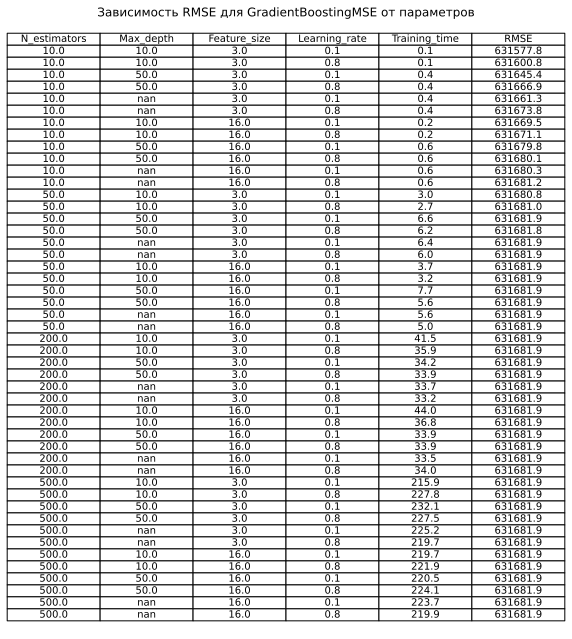

In [14]:
plt.figure(figsize=(10, 11))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('Зависимость RMSE для GradientBoostingMSE от параметров')

table_data = results_df[['N_estimators', 'Max_depth', 'Feature_size', 'Learning_rate', 'Training_time', 'RMSE']]
table = plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
plt.savefig('2.pdf', bbox_inches='tight')
plt.show()